In [59]:
import networkx as nx
import networkx.algorithms.approximation as nx_app
import random
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.optimize import LinearConstraint
import numpy as np
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [60]:
G = nx.DiGraph()
G.add_edge("s", "a", capacity=3.0)
G.add_edge("s", "b", capacity=2.0)
G.add_edge("a", "c", capacity=4.0)
G.add_edge("b", "c", capacity=1.0)
G.add_edge("b", "d", capacity=2.0)
G.add_edge("d", "e", capacity=3.0)
G.add_edge("c", "t", capacity=2.0)
G.add_edge("e", "t", capacity=2.0)

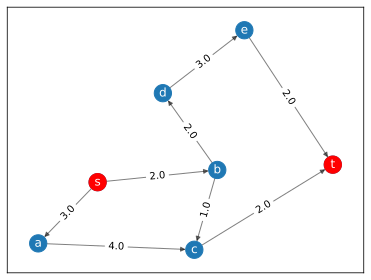

In [61]:
# draw graph with capacities and S and T nodes in red
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300)
nx.draw_networkx_nodes(G, pos, nodelist=["s", "t"], node_size=300, node_color="r")
nx.draw_networkx_labels(G, pos, font_color="w")
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
edge_labels = nx.get_edge_attributes(G, 'capacity')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [62]:
# enumerate all paths from s to t
paths = list(nx.all_simple_paths(G, "s", "t"))
paths

[['s', 'a', 'c', 't'], ['s', 'b', 'c', 't'], ['s', 'b', 'd', 'e', 't']]

In [63]:
# to maximize flow, solve the LP problem maximizing the flow on each path, subject to the constraint that the sum of flows of all paths containing an edge is less than the capacity of that edge
c = np.ones(len(paths))
A = np.zeros((len(G.edges),len(paths)))
b_u = np.array([nx.get_edge_attributes(G, 'capacity')[e] for e in G.edges])
b_l = np.zeros(len(G.edges))

for i, path in enumerate(paths):
    for j, edge in enumerate(G.edges):
        if edge in zip(path, path[1:]):
            A[j, i] = 1
            
constraints = LinearConstraint(A, b_l, b_u)
res = linprog(-c, A_ub=A, b_ub=b_u, bounds=(0, None))
res

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -4.0
              x: [ 2.000e+00  0.000e+00  2.000e+00]
            nit: 0
          lower:  residual: [ 2.000e+00  0.000e+00  2.000e+00]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 1.000e+00  0.000e+00  2.000e+00  1.000e+00
                              0.000e+00  0.000e+00  1.000e+00  0.000e+00]
                 marginals: [-0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00
                             -1.000e+00 -1.000e+00 -0.000e+00 -0.000e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

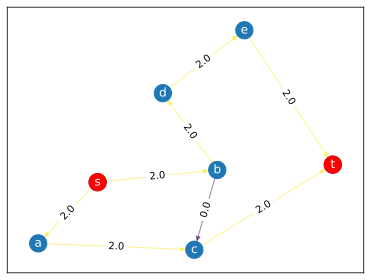

In [66]:
# draw flow on graph
flow = res.x
flow_dict = {e: 0 for e in G.edges}
for i, path in enumerate(paths):
    for j, edge in enumerate(G.edges):
        if edge in zip(path, path[1:]):
            flow_dict[edge] += flow[i]


nx.draw_networkx_nodes(G, pos, node_size=300)
nx.draw_networkx_nodes(G, pos, nodelist=["s", "t"], node_size=300, node_color="r")
nx.draw_networkx_labels(G, pos, font_color="w")
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edgelist=flow_dict.keys(), edge_color=flow_dict.values())
nx.draw_networkx_edge_labels(G, pos, edge_labels=flow_dict)
plt.show()